# Исследование объявлений о продаже квартир

Учебный проект на данных Яндекс.Недвижимость — архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

Задача - научиться определять рыночную стоимость объектов недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Цель исследования:

1. Определить, сколько по времени обычно происходит продажа жилья.
2. Определить, какия факторы больше всего влияют на полную стоимость жилья.
3. Определить стоимость квадратного метра в разных локациях. Определить, какие факторы влияют на стоимость квадратного метра, и чем они отличаются от факторов, влияющих на полную стоимость.
4. Описать, как изменяется полная стоимость жилья в Санкт-Петербурге при удалении от центра города.

Ход исследования.
О качестве данных ничего не известно, поэтому для проведения исследования нобходимо будет пройти следующие шаги:
* Проверить объем данных и количество пропусков. Заполнить по возможности. Изложить возможные причины появления.
* Проверить наличие ошибок в данных. Неявные дубликаты. Некорректные типы данных. Исправить по возможности.
* Проверить разброс значений в данных. Удалить аномалии и сильно выбивающиеся значения, которые могли бы исказить конечный результат.
* Изучить приведенные параметры. Дополнить данные расчетными параметрами.
* Провести исследование в соответствии с поставленными целями.
* Общий вывод. Также дать рекомендации по сбору данных, оставить комментарии о найденных недочетах.

## Import, info

In [1]:
# !pip install pymystem3 wordcloud phik -q

In [2]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from phik import phik_matrix
from pymystem3 import Mystem
import seaborn as sns
from wordcloud import WordCloud

m = Mystem()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

warnings.filterwarnings('ignore')

In [3]:
try:
    data = pd.read_csv('C:/Users/anton/OneDrive/data_science/practicum_projects/datasets/real_estate_data.csv', sep="\t")
except:
    print('Path not found')

### Общая информация о данных

In [4]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [5]:
# Поменяем порядок столбцов для удобства
data = data[['last_price', 'total_area', 'living_area', 'kitchen_area',
        'rooms', 'is_apartment', 'studio', 'open_plan',
        'ceiling_height', 'floor', 'floors_total', 
        'balcony', 'locality_name', 'airports_nearest', 'cityCenters_nearest',
        'parks_around3000', 'parks_nearest', 'ponds_around3000',
        'ponds_nearest','first_day_exposition', 'days_exposition', 'total_images']]

In [6]:
# Немного переименуем колонки
data = data.rename(columns={
    'cityCenters_nearest': 'city_centers_nearest',
    'parks_around3000': 'parks_around_3000',
    'ponds_around3000': 'ponds_around_3000'
})

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            23699 non-null  float64
 1   total_area            23699 non-null  float64
 2   living_area           21796 non-null  float64
 3   kitchen_area          21421 non-null  float64
 4   rooms                 23699 non-null  int64  
 5   is_apartment          2775 non-null   object 
 6   studio                23699 non-null  bool   
 7   open_plan             23699 non-null  bool   
 8   ceiling_height        14504 non-null  float64
 9   floor                 23699 non-null  int64  
 10  floors_total          23613 non-null  float64
 11  balcony               12180 non-null  float64
 12  locality_name         23650 non-null  object 
 13  airports_nearest      18157 non-null  float64
 14  city_centers_nearest  18180 non-null  float64
 15  parks_around_3000  

В некоторых колонках присутствует большое количество пропусков - нужно будет проанализировать. Также типы данных требуют корректировки.

### Предобработка данных

In [8]:
data.head()

,last_price,total_area,living_area,kitchen_area,rooms,is_apartment,studio,open_plan,ceiling_height,floor,floors_total,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,first_day_exposition,days_exposition,total_images
0,13000000.0,108.0,51.0,25.0,3,NaN,False,False,2.70,8,16.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,2019-03-07T00:00:00,NaN,20
1,3350000.0,40.4,18.6,11.0,1,NaN,False,False,NaN,1,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,2018-12-04T00:00:00,81.0,7
2,5196000.0,56.0,34.3,8.3,2,NaN,False,False,NaN,4,5.0,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,2015-08-20T00:00:00,558.0,10
3,64900000.0,159.0,NaN,NaN,3,NaN,False,False,NaN,9,14.0,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,2015-07-24T00:00:00,424.0,0
4,10000000.0,100.0,32.0,41.0,2,NaN,False,False,3.03,13,14.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,2018-06-19T00:00:00,121.0,2


#### Nan data

In [9]:
# % пропусков по столбцам
round(data.isna().mean()*100,3).sort_values(ascending=False)\
        .to_frame().style.background_gradient('coolwarm')

,0
is_apartment,88.291000
parks_nearest,65.910000
ponds_nearest,61.560000
balcony,48.605000
ceiling_height,38.799000
airports_nearest,23.385000
city_centers_nearest,23.288000
parks_around_3000,23.284000
ponds_around_3000,23.284000
days_exposition,13.423000


Пропуски, которые мы можем заполнить:
* `is_apartment`, `balcony` - заполнить значением 'False'

Пропуски, которые нужно удалить:
* `locality_name` - важный показатель, без которого оценка стоимости невозможна

В остальных столбцах оставляем пропуски как есть

In [10]:
# Заполняем пропуски, которые можно заполнить
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)

# Удаляем пропуски, которые нельзя оставлять
data = data.dropna(subset=['locality_name'])

Посмотрим на данные с пропусками в `airports_nearest`, `city_centers_nearest`, `parks_around_3000`, `parks_nearest`, `ponds_around_3000` и `ponds_nearest`

In [11]:
# Пример данных с пропусками в `airport_nearest`
data[data['airports_nearest'].isna()].sample(5)

,last_price,total_area,living_area,kitchen_area,rooms,is_apartment,studio,open_plan,ceiling_height,floor,floors_total,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,first_day_exposition,days_exposition,total_images
20342,630000.0,39.0,25.5,6.0,2,False,False,False,NaN,4,5.0,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-15T00:00:00,68.0,7
20998,3950000.0,65.8,38.0,10.4,2,False,False,False,2.70,6,8.0,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-05T00:00:00,222.0,9
13279,2370000.0,34.5,18.0,9.0,1,False,False,False,NaN,3,4.0,1.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-24T00:00:00,32.0,11
9169,1890000.0,30.7,17.0,6.5,1,False,False,False,2.55,4,5.0,1.0,Кировск,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-03T00:00:00,116.0,12
10660,1990000.0,44.0,24.3,5.8,2,False,False,False,2.60,3,4.0,0.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-22T00:00:00,329.0,11


Столбцы `airports_nearest`, `city_centers_nearest`, `parks_around_3000`, `parks_nearest`, `ponds_around_3000` и `ponds_nearest` имеют пропуски практически в одних и тех же строках.

In [12]:
# Каким значениям в `parks_around_3000` соответствуют пропуски в `parks_nearest`
data[data['parks_nearest'].isna()]['parks_around_3000'].unique()

array([ 0., nan])

In [13]:
# Каким значениям в `ponds_around_3000` соответствуют пропуски в `ponds_nearest`
data[data['ponds_nearest'].isna()]['ponds_around_3000'].unique()

array([ 0., nan])

Дополнительно, пропуски в `parks_nearest` и `ponds_nearest` соответствуют либо нулям в `parks_around_3000` и `ponds_around_3000`, либо пропущенным значениям в этих столбцах.

#### Data types

In [14]:
data.dtypes

last_price              float64
total_area              float64
living_area             float64
kitchen_area            float64
rooms                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
ceiling_height          float64
floor                     int64
floors_total            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around_3000       float64
parks_nearest           float64
ponds_around_3000       float64
ponds_nearest           float64
first_day_exposition     object
days_exposition         float64
total_images              int64
dtype: object

In [15]:
# 'first_day_exposition' нужно перевести в формат даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# Поменяем не NaN значение 'floors_total' на целые числа
data['floors_total'] = data.dropna(subset=['floors_total'])['floors_total'].astype('int64')

# Изменим тип данных в 'is_apartment' на boolean
data['is_apartment'] = data['is_apartment'].astype('bool')

# Изменим тип данных в 'balcony' на целые числа
data['balcony'] = data['balcony'].astype('int64')

# Также преобразуем цену жилья в млн.руб.
data['last_price_mln'] = data['last_price'] / 10**6
data.drop(columns=['last_price'], inplace=True)

#### Duplicated values

In [16]:
data[data.duplicated()]

,total_area,living_area,kitchen_area,rooms,is_apartment,studio,open_plan,ceiling_height,floor,floors_total,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,first_day_exposition,days_exposition,total_images,last_price_mln


Явные дубликаты отсутствуют

#### Лемматизация `locality_name`

Применим лемматизацию названий для исключения неявных дубликатов в названиях

In [17]:
# Лемматизация работает следующим образом:
m.lemmatize('Очень странное название Тридевятого Царства')

['очень',
 ' ',
 'странный',
 ' ',
 'название',
 ' ',
 'тридевятый',
 ' ',
 'царство',
 '\n']

In [18]:
unique_names = data['locality_name'].unique()
uniques_before = len(unique_names)
# сложная конструкция, чтобы лемматизировать одну строку вместо списка:
lemmas = ''.join(m.lemmatize(';'.join(unique_names))).split(';')

# Series с лемматизированными названиями в значениях
names_lemmas = pd.Series(data=lemmas, index=unique_names)

# Series с лемматизированными названиями в индексах
# Таким образом уберутся неявные дубликаты в названиях
lemmas_names = pd.Series(data=names_lemmas.drop_duplicates().index, index=names_lemmas.drop_duplicates())

data['locality_lemm_name'] = data['locality_name'].map(names_lemmas) # подставляем леммы по названиям
data['locality_name'] = data['locality_lemm_name'].map(lemmas_names) # убираем неявные дубликаты по леммам

uniques_after = len(data['locality_lemm_name'].unique())
print('Было уникальных названий:', uniques_before)
print('Стало уникальных названий:', uniques_after)
data.sample(5)

Было уникальных названий: 364
Стало уникальных названий: 331


,total_area,living_area,kitchen_area,rooms,is_apartment,studio,open_plan,ceiling_height,floor,floors_total,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,first_day_exposition,days_exposition,total_images,last_price_mln,locality_lemm_name
18254,39.0,17.00,10.50,1,False,False,False,NaN,10,10.0,1,Колпино,25724.0,31510.0,1.0,349.0,0.0,NaN,2017-09-26,12.0,17,3.00,колпино
222,59.6,31.48,13.29,2,False,False,False,NaN,17,25.0,0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,2018-05-08,182.0,7,5.95,санкт-петербург
6955,42.0,19.00,10.00,1,False,False,False,NaN,1,8.0,0,Красное Село,27164.0,30589.0,0.0,NaN,0.0,NaN,2017-11-11,82.0,0,3.20,красный село
4005,46.0,31.00,6.00,2,False,False,False,NaN,5,5.0,1,Санкт-Петербург,32689.0,9767.0,1.0,480.0,0.0,NaN,2016-04-06,93.0,7,4.10,санкт-петербург
9530,38.0,20.00,8.00,1,False,False,False,NaN,2,12.0,0,Санкт-Петербург,32079.0,5038.0,0.0,NaN,3.0,537.0,2015-07-15,536.0,7,4.60,санкт-петербург


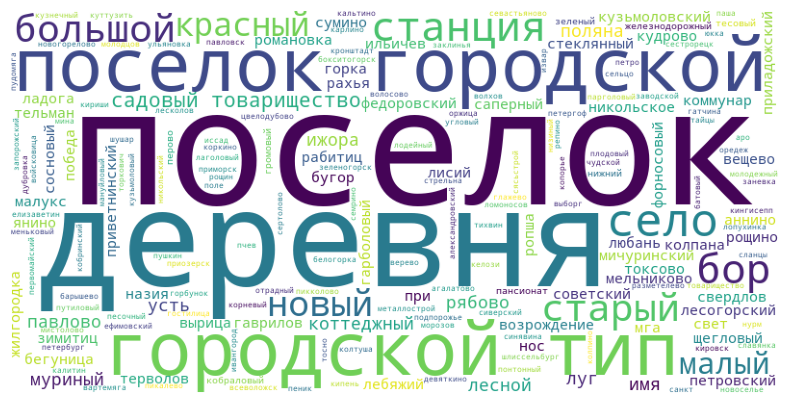

In [19]:
# Для наглядности можно создать облако слов из мешка со всеми словами в названиях
all_lemas = ' '.join(lemmas)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lemas)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

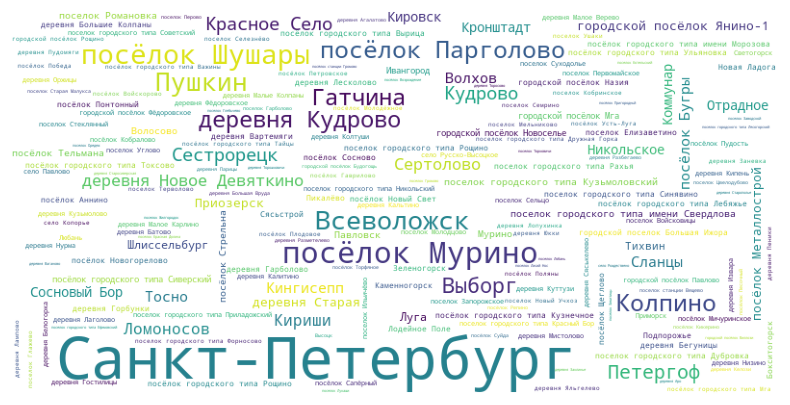

In [20]:
# И облако слов по названиям населенных пунктов
all_names = data['locality_name'].value_counts().to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Изучение аномалий

In [21]:
data.describe()

,total_area,living_area,kitchen_area,rooms,ceiling_height,floor,floors_total,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,first_day_exposition,days_exposition,total_images,last_price_mln
count,23650.000000,21752.000000,21381.000000,23650.000000,14490.000000,23650.000000,23565.000000,23650.000000,18116.000000,18139.000000,18140.000000,8064.000000,18140.000000,9085.000000,23650,20470.000000,23650.000000,23650.000000
mean,60.329069,34.448356,10.566403,2.070106,2.771287,5.893277,10.675875,0.591712,28803.225878,14197.860742,0.611577,490.830729,0.769680,518.059879,2017-11-10 00:03:57.463002112,180.753200,9.862326,6.541127
min,12.000000,2.000000,1.300000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,2014-11-27 00:00:00,1.000000,0.000000,0.012190
25%,40.000000,18.600000,7.000000,1.000000,2.520000,2.000000,5.000000,0.000000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,2017-05-15 00:00:00,45.000000,6.000000,3.400000
50%,52.000000,30.000000,9.100000,2.000000,2.650000,4.000000,9.000000,0.000000,26756.500000,13105.000000,0.000000,454.500000,1.000000,502.000000,2017-12-12 00:00:00,95.000000,9.000000,4.650000
75%,69.700000,42.300000,12.000000,3.000000,2.800000,8.000000,16.000000,1.000000,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,2018-08-27 00:00:00,231.000000,14.000000,6.799000
max,900.000000,409.700000,112.000000,19.000000,100.000000,33.000000,60.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,2019-05-03 00:00:00,1580.000000,50.000000,763.000000
std,35.661808,22.037664,5.901753,1.078620,1.261593,4.883317,6.594823,0.959662,12637.314144,8606.830295,0.802003,342.554386,0.937948,277.841733,NaN,219.777916,5.682278,10.896399


In [22]:
# Для удобства выведем отдельно таблицу с перцентилями
def percent_1(x):
    return x.quantile(0.01)

def percent_5(x):
    return x.quantile(0.05)

def percent_95(x):
    return x.quantile(0.95)

df_percentiles = data.select_dtypes(include='number').agg(['min', percent_1, percent_5, percent_95, 'max']).T
df_percentiles

,min,percent_1,percent_5,percent_95,max
total_area,12.00000,25.1745,31.0000,116.00,900.0
living_area,2.00000,13.0000,15.2000,69.00,409.7
kitchen_area,1.30000,5.0000,5.5000,20.00,112.0
rooms,0.00000,1.0000,1.0000,4.00,19.0
ceiling_height,1.00000,2.5000,2.5000,3.30,100.0
floor,1.00000,1.0000,1.0000,16.00,33.0
floors_total,1.00000,2.0000,4.0000,25.00,60.0
balcony,0.00000,0.0000,0.0000,2.00,5.0
airports_nearest,0.00000,9412.1500,11567.7500,51340.00,84869.0
city_centers_nearest,181.00000,1327.3800,3541.0000,31651.10,65968.0


In [23]:
data.columns

Index(['total_area', 'living_area', 'kitchen_area', 'rooms', 'is_apartment',
       'studio', 'open_plan', 'ceiling_height', 'floor', 'floors_total',
       'balcony', 'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'first_day_exposition', 'days_exposition',
       'total_images', 'last_price_mln', 'locality_lemm_name'],
      dtype='object')

Нужно обработать значения в столбцах:
* `last_price` - смещенная выборка и присутствуют выбросы. Ограничить диапазон цен исследуемых квартир.
* `total_area`, `living_area`, `kitchen_area` - выбросы. Ограничить диапазон площади исследуемого жилья.
* `rooms` - выбросы. Ограничиться самыми популярными значениями.
* `is_apartment`, `studio`, `open_plan` - очень высокий дисбаланс. Оставить для исследования только значения False / удалить столбцы вообще, т.к. они будут неинформативны
* `ceiling_height` - выбросы, удалить редкие значения
* `balcony` - выбросы, удалить редкие значения
* `locality_name` - объединить названия с маленьким количеством объявлений в одну группу

Выбранные столбцы предлагаю ограничить по 95% перцентилю сверху, а цену и высоту потолков еще и по 1% снизу

Оставляем как есть:
* `airports_nearest`, `city_centers_nearest`, `parks_around_300`, `parks_neares`, `ponds_around_300` и `ponds_nearest` - выглядят адекватно, оставляем как есть
* `floor`, `floors_total` - также оставляем как есть
* `first_day_exposition`, `days_exposition` - оставляем как есть
* `total_images` - оставляем как есть

In [24]:
good_data = data.copy()
rows_before = len(good_data)
print('Количество строк до удаления:', rows_before)

# Оставляем только "не апартаменты", "не студии" и "не свободная планировка"
good_data = good_data[good_data['is_apartment']==False]
good_data = good_data[good_data['studio']==False]
good_data = good_data[good_data['open_plan']==False]
good_data = good_data.drop(['is_apartment', 'studio', 'open_plan'], axis=1)

# Оставляем только столбцы под очистку
names_top_limit = ['last_price_mln', 'total_area', 'living_area', 'kitchen_area', 'rooms',
                     'ceiling_height', 'balcony']
names_bottom_limit = ['last_price_mln', 'ceiling_height']

# Очищаем по верхнему и нижнему пределу
for column in names_bottom_limit:
    good_data = good_data[(good_data[column] >= df_percentiles.loc[column, 'percent_1']) | good_data[column].isna()]

for column in names_top_limit:
    good_data = good_data[(good_data[column] <= df_percentiles.loc[column, 'percent_95']) | good_data[column].isna()]

# Добавляем новый столбец в сводную таблицу
df_percentiles['max_after_cut'] = good_data.max()

rows_after = len(good_data)
print('Количество строк после удаления:', rows_after)
print(f'Осталось {(rows_after / rows_before):.1%} данных')
display(df_percentiles)

Количество строк до удаления: 23650
Количество строк после удаления: 20102
Осталось 85.0% данных


,min,percent_1,percent_5,percent_95,max,max_after_cut
total_area,12.00000,25.1745,31.0000,116.00,900.0,116.0
living_area,2.00000,13.0000,15.2000,69.00,409.7,69.0
kitchen_area,1.30000,5.0000,5.5000,20.00,112.0,20.0
rooms,0.00000,1.0000,1.0000,4.00,19.0,4
ceiling_height,1.00000,2.5000,2.5000,3.30,100.0,3.3
floor,1.00000,1.0000,1.0000,16.00,33.0,33
floors_total,1.00000,2.0000,4.0000,25.00,60.0,60.0
balcony,0.00000,0.0000,0.0000,2.00,5.0,2
airports_nearest,0.00000,9412.1500,11567.7500,51340.00,84869.0,84869.0
city_centers_nearest,181.00000,1327.3800,3541.0000,31651.10,65968.0,65968.0


### Посчитайте и добавьте в таблицу новые столбцы

In [25]:
# Цена за квадратный метр
good_data['price_per_m2'] = good_data['last_price_mln'] / good_data['total_area'] * 10**6

# Выделение недели, месяца и года продажи
good_data['first_day_exposition_weekday'] = good_data['first_day_exposition'].values.astype('datetime64[W]')
good_data['first_day_exposition_month'] = good_data['first_day_exposition'].values.astype('datetime64[M]')
good_data['first_day_exposition_year'] = good_data['first_day_exposition'].dt.year

# Топ-10 населенных пунктов по количеству объявлений
top_10 = good_data['locality_name'].value_counts(ascending=False).head(10).index.tolist()
# Добавляем группу 'other' для городов, которые не входят в топ-10
good_data['locality_name_group'] = np.where(good_data['locality_name'].isin(top_10), good_data['locality_name'], 'other')

# Добавляем тип этажа: первый, последний, или остальные
def floor_type(line):
    if line['floor'] == 1:
        return 'first'
    elif line['floor'] == line['floors_total']:
        return 'last'
    else:
        return 'other'
good_data['floor_type'] = good_data.apply(floor_type, axis=1)

# Добавим значение удаленности от центра в км
good_data['city_centers_nearest_km'] = round(good_data['city_centers_nearest'] / 1000)

# Разбивка на группы по удаленности от центра
good_data['distance_cats'] = pd.cut(good_data['city_centers_nearest_km'],
                                    bins=[float('-inf'),5,10,15,20,25,30, float('inf')],
                                    labels=['< 5 km', '5 - 10 km', '10 - 15 km','15 - 20 km',
                                            '20 - 25 km','25 - 30 km', '> 30 km'])

In [26]:
good_data.head()

,total_area,living_area,kitchen_area,rooms,ceiling_height,floor,floors_total,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,first_day_exposition,days_exposition,total_images,last_price_mln,locality_lemm_name,price_per_m2,first_day_exposition_weekday,first_day_exposition_month,first_day_exposition_year,locality_name_group,floor_type,city_centers_nearest_km,distance_cats
1,40.4,18.6,11.0,1,NaN,1,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,2018-12-04,81.0,7,3.350,поселок шушар,82920.792079,2018-11-29,2018-12-01,2018,посёлок Шушары,first,19.0,15 - 20 km
2,56.0,34.3,8.3,2,NaN,4,5.0,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,2015-08-20,558.0,10,5.196,санкт-петербург,92785.714286,2015-08-20,2015-08-01,2015,Санкт-Петербург,other,14.0,10 - 15 km
5,30.4,14.4,9.1,1,NaN,5,12.0,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-10,55.0,10,2.890,городской поселок янино-1,95065.789474,2018-09-06,2018-09-01,2018,other,other,NaN,NaN
6,37.3,10.6,14.4,1,NaN,6,26.0,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,2017-11-02,155.0,6,3.700,поселок парголовый,99195.710456,2017-11-02,2017-11-01,2017,посёлок Парголово,other,19.0,15 - 20 km
7,71.6,NaN,18.9,2,NaN,22,24.0,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,2019-04-18,NaN,5,7.915,санкт-петербург,110544.692737,2019-04-18,2019-04-01,2019,Санкт-Петербург,other,12.0,10 - 15 km


### EDA

#### Информация о `days_exposition`

In [27]:
good_data['days_exposition'].describe()

count    17701.000000
mean       172.427264
std        211.236290
min          1.000000
25%         43.000000
50%         91.000000
75%        217.000000
max       1553.000000
Name: days_exposition, dtype: float64

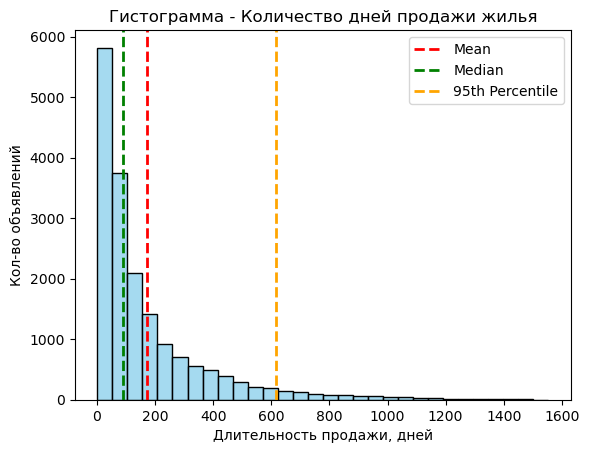

Среднее значение дней продажи: 172 дней
Медианное значение дней продажи: 91 дней
95% перцентиль: 616 дней


In [28]:
# Создадим гистограмму частот для количества дней размещения объявления
sns.histplot(good_data['days_exposition'], bins=30, color='skyblue')

# Посчитаем среднее, медиану и 95% перцентиль
mean_val = good_data['days_exposition'].mean()
median_val = good_data['days_exposition'].median()
percentile_95 = good_data['days_exposition'].quantile(0.95)

# Добавим линии среднего, медианы и 95% перцентиля
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=2, label='95th Percentile')

plt.title('Гистограмма - Количество дней продажи жилья')
plt.xlabel('Длительность продажи, дней')
plt.ylabel('Кол-во объявлений')
plt.legend()

plt.show()

print(f'Среднее значение дней продажи: {round(mean_val)} дней\n'\
f'Медианное значение дней продажи: {round(median_val)} дней\n'\
f'95% перцентиль: {round(percentile_95)} дней')

На мой взгляд, все, что продавалось быстрее медианного значения 90 дней можно посчитать быстрой продажей. Все, что выходит за предел 95% перцентиля = 614 дней, можно посчитать слишком долгой продажей.

#### Коэффициенты корреляции

Для исследования корреляции между признаками я буду использовтаь коэффициент коррелфции $\phi$

In [29]:
phik_matrix_result = phik_matrix(good_data)
price_coefs = pd.DataFrame({
    'last_price':phik_matrix_result['last_price_mln'].drop(['last_price_mln', 'price_per_m2']),
    'price_per_m2':phik_matrix_result['price_per_m2'].drop(['last_price_mln', 'price_per_m2'])
})
price_coefs.sort_values('last_price', ascending=False).style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'floor', 'floors_total', 'balcony', 'airports_nearest', 'city_centers_nearest', 'parks_around_3000', 'parks_nearest', 'ponds_around_3000', 'ponds_nearest', 'days_exposition', 'total_images', 'last_price_mln', 'price_per_m2', 'first_day_exposition_year', 'city_centers_nearest_km']


,last_price,price_per_m2
total_area,0.713701,0.163849
locality_lemm_name,0.642423,0.732493
locality_name,0.642423,0.732493
living_area,0.597948,0.170581
kitchen_area,0.513624,0.229664
ceiling_height,0.474484,0.274115
locality_name_group,0.464209,0.508754
city_centers_nearest_km,0.449167,0.350398
city_centers_nearest,0.447347,0.347461
rooms,0.436549,0.198895


Влияние на общую цену жилья
* Больше всего на цену жилья влияет площадь этого жилья. Причем общая площадь имеет большее значение, чем площади кухни или жилой зоны в отдельности.
* Название населенного пункта на 2 месте по влиянию на цену  
* Дальше по значимости идет высота потолков и удаленность от центра города    
* Дальше - количество комнат. Но это можно рассматривать как косвенный признак общей площади.  
* Также небольшое влияние оказывает этаж квартиры, этажность здания и тип этажа
* Удаленность парков, прудов и аэропорта оказывают наименьшее влияние на цену, как и наличие балкона

Влияние на цену за 1 квадратный метр
* На цену за квадратный метр основное влияние оказывает название населенного пункта, остальные параметры оказывают значительно меньшее влияние. Из таких можно выделить удаленность от центра и количество этажей у дома.

#### Зависимость цены от площади

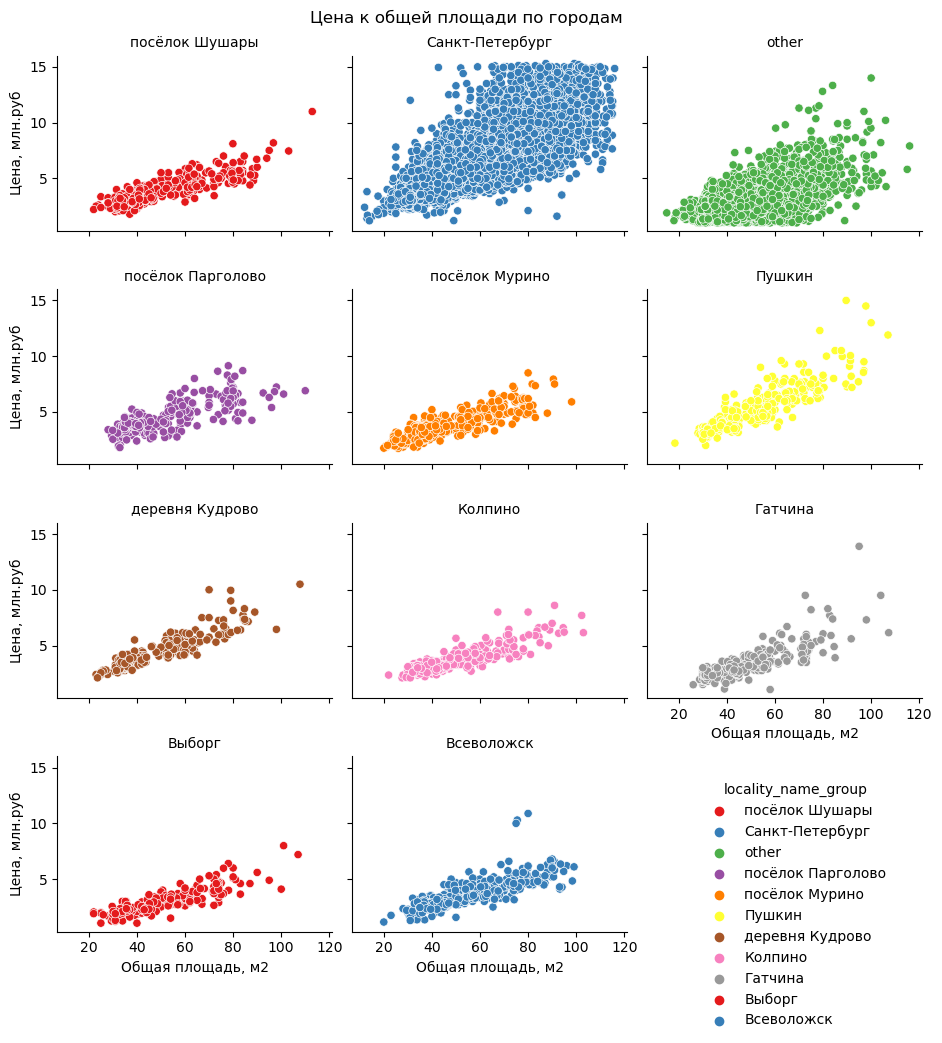

In [30]:
area_plots = sns.relplot(
    data=good_data,
    x='total_area',
    y='last_price_mln',
    hue='locality_name_group',
    col='locality_name_group',
    col_wrap=3,
    height=2.5,
    palette='Set1'
)

area_plots.fig.suptitle('Цена к общей площади по городам')
area_plots.set_titles(col_template="{col_name}")

# Можно изменить подписи осей
area_plots.set_axis_labels('Общая площадь, м2', 'Цена, млн.руб')

# Можно настроить положение легенды в bbox_to_anchor
sns.move_legend(area_plots, loc='lower center', bbox_to_anchor=(0.85, -0.05)) 

plt.tight_layout()
plt.show()

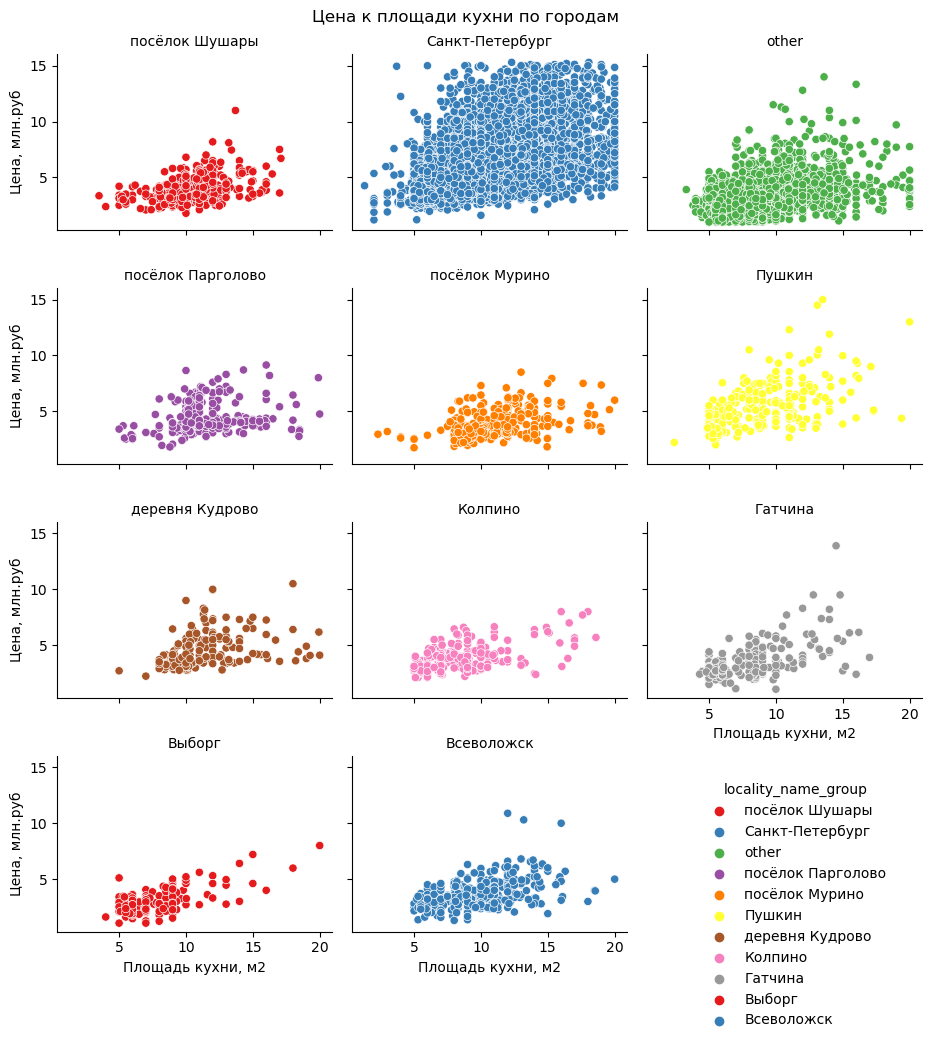

In [31]:
# Зависимость цены от площади кухни
area_plots = sns.relplot(
    data=good_data,
    x='kitchen_area',
    y='last_price_mln',
    hue='locality_name_group',
    col='locality_name_group',
    col_wrap=3,
    height=2.5,
    palette='Set1'
)

area_plots.fig.suptitle('Цена к площади кухни по городам')
area_plots.set_titles(col_template="{col_name}")

# Можно изменить подписи осей
area_plots.set_axis_labels('Площадь кухни, м2', 'Цена, млн.руб')

# Можно настроить положение легенды в bbox_to_anchor
sns.move_legend(area_plots, loc='lower center', bbox_to_anchor=(0.85, -0.05)) 

plt.tight_layout()
plt.show()

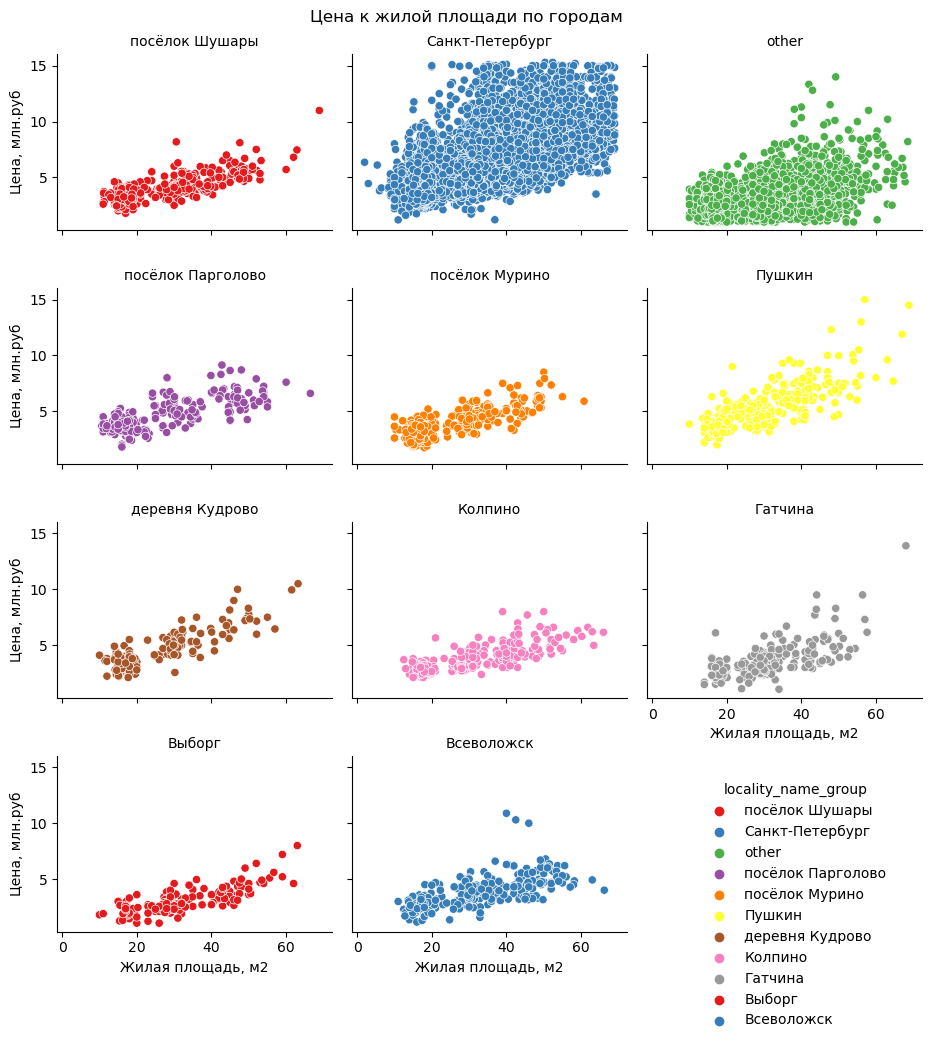

In [32]:
# Зависимость цены от жилой площади
area_plots = sns.relplot(
    data=good_data,
    x='living_area',
    y='last_price_mln',
    hue='locality_name_group',
    col='locality_name_group',
    col_wrap=3,
    height=2.5,
    palette='Set1'
)

area_plots.fig.suptitle('Цена к жилой площади по городам')
area_plots.set_titles(col_template="{col_name}")

# Можно настроить положение легенды в bbox_to_anchor
sns.move_legend(area_plots, loc='lower center', bbox_to_anchor=(0.85, -0.05))

# Можно изменить подписи осей
area_plots.set_axis_labels('Жилая площадь, м2', 'Цена, млн.руб')

plt.tight_layout()
plt.show()

Как мы и получили на матрице корреляции, зависимость цены от общей площади более четкая, нежели зависимость от площади кухни или жилой площади  
У Санкт-Петербурга разброс цен довольно большой, т.к. присутствуют другие факторы, влияющие на цену. В других населенных пунктах зависимость от площади более четкая, т.к. общая площадь - это основной показатель стоимости жилья

#### Зависимость цены от кол-ва комнат, типа этажа, года публикации.

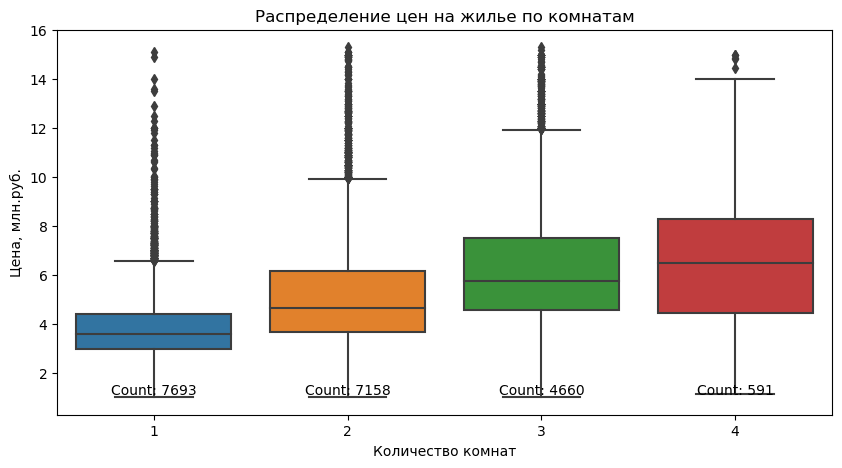

In [33]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='rooms', y='last_price_mln', data=good_data)
plt.xlabel('Количество комнат')
plt.ylabel('Цена, млн.руб.')
plt.title('Распределение цен на жилье по комнатам')

counts = good_data['rooms'].value_counts()
xticks_positions = ax.get_xticks()
xticks_labels = [int(i.get_text()) for i in ax.get_xticklabels()]

for i, j in zip(xticks_positions, xticks_labels):
    ax.text(i, good_data['last_price_mln'].min(), f'Count: {counts[j]}', ha='center', va='bottom')

plt.show()

Чем больше комнат - тем выше стоимость. Причем за 4-коматные квартиры разброс цен самый большой.

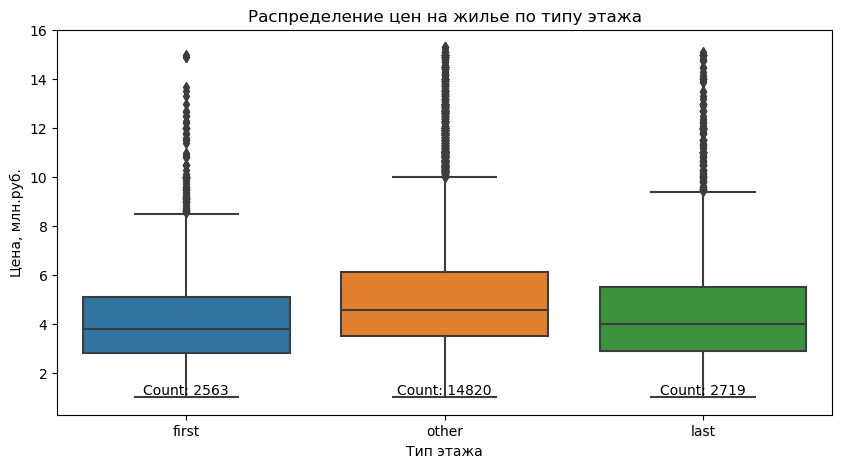

In [34]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='floor_type', y='last_price_mln', data=good_data)
plt.xlabel('Тип этажа')
plt.ylabel('Цена, млн.руб.')
plt.title('Распределение цен на жилье по типу этажа')

counts = good_data['floor_type'].value_counts()
xticks_positions = ax.get_xticks()
xticks_labels = [i.get_text() for i in ax.get_xticklabels()]

for i, j in zip(xticks_positions, xticks_labels):
    ax.text(i, good_data['last_price_mln'].min(), f'Count: {counts[j]}', ha='center', va='bottom')
    
plt.show()

Жилье не на первом / последнем этажах стоит немного дороже

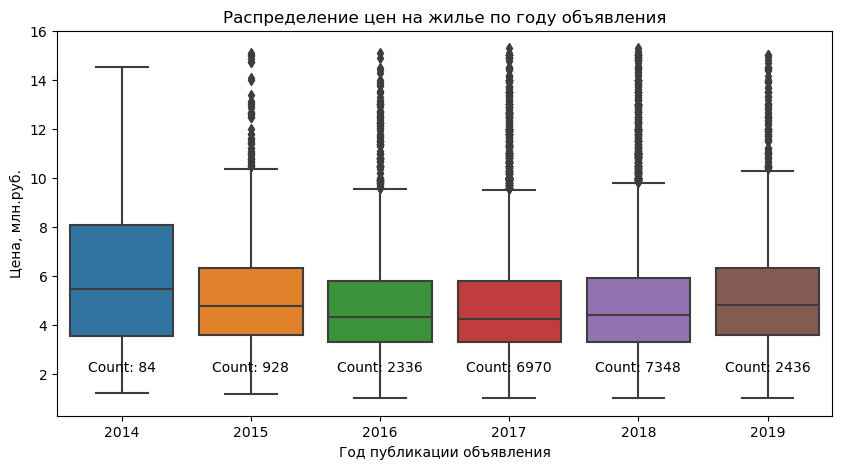

In [35]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='first_day_exposition_year', y='last_price_mln', data=good_data)
plt.xlabel('Год публикации объявления')
plt.ylabel('Цена, млн.руб.')
plt.title('Распределение цен на жилье по году объявления')

counts = good_data['first_day_exposition_year'].value_counts()
xticks_positions = ax.get_xticks()
xticks_labels = [int(i.get_text()) for i in ax.get_xticklabels()]

for i, j in zip(xticks_positions, xticks_labels):
    ax.text(i, good_data['last_price_mln'].min() + 1, f'Count: {counts[j]}', ha='center', va='bottom')

plt.show()

2104 год не совсем репрезентативный - всего 84 примера. С 2014 по 2016 наблюдалось снижение цен на жилье. С 2017 цены на жилье постепенно растут.

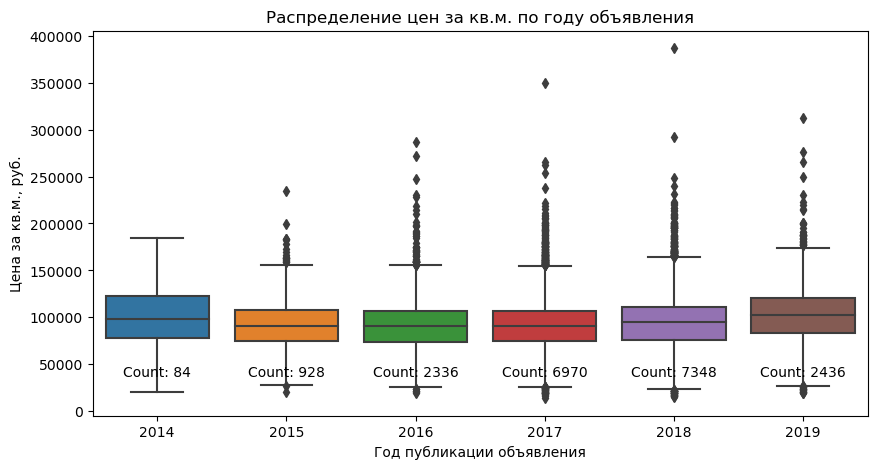

In [36]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='first_day_exposition_year', y='price_per_m2', data=good_data)
plt.xlabel('Год публикации объявления')
plt.ylabel('Цена за кв.м., руб.')
plt.title('Распределение цен за кв.м. по году объявления')

counts = good_data['first_day_exposition_year'].value_counts()
xticks_positions = ax.get_xticks()
xticks_labels = [int(i.get_text()) for i in ax.get_xticklabels()]

for i, year in zip(xticks_positions, xticks_labels):
    ax.text(i, good_data['price_per_m2'].min() + 20000, f'Count: {counts[year]}', ha='center', va='bottom')

plt.show()

In [37]:
prices_per_year = good_data.groupby('first_day_exposition_year').agg(count=('last_price_mln', 'count'),
                                                  last_price=('last_price_mln', 'median'),
                                                  price_per_m2=('price_per_m2', 'median'))

round(prices_per_year, 1)

,count,last_price,price_per_m2
first_day_exposition_year,,,
2014,84,5.5,98051.9
2015,928,4.8,90533.4
2016,2336,4.3,90260.8
2017,6970,4.2,90495.1
2018,7348,4.4,94698.6
2019,2436,4.8,101932.8


Учитывать: за 2014 год всего 84 примера.

Начиная с 2014 года наблюдался спад цены до 2016 года. С 2017 цена плавно поднимается. Цена за 1 квадратный метр в свою очередь плавно поднимается с 2015 года.

В целом, на 2019 год уровень цен на рынке остался примерно на уровне 2015 года, но при этом увеличилась доля жилья с более дорогим квадратным метром.

#### Цены за кв.м. в разных населенных пунктах

<Axes: title={'center': 'Цены за 1 квадратный метр'}, ylabel='Цена, млн.руб.'>

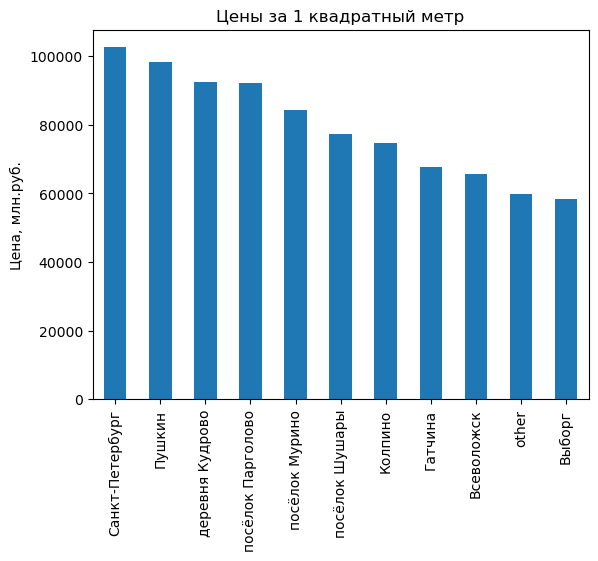

In [38]:
# Цены за 1м2
good_data_price_per_m2 = good_data.groupby('locality_name_group')['price_per_m2'].\
                            agg(['count', 'median']).sort_values('median', ascending=False)
good_data_price_per_m2['median'].plot(
    kind='bar',
    xlabel='',
    ylabel='Цена, млн.руб.',
    title='Цены за 1 квадратный метр'
)

Самый дорогой м2 - в Санкт-Петербурге. В населенных пунктах Пушкин, деревня Кудрово и поселок Парголово цена за квадратный метр не намного дешевле. Медианная цена в группе `other` - около 60000 руб. за кв.м.

Посмотрим, что больше влияет на цену за 1м2 в Питере

In [39]:
data_peter = good_data[good_data['locality_name'] == 'Санкт-Петербург']

phik_matrix_result = phik_matrix(data_peter)
price_coefs = pd.DataFrame(phik_matrix_result['price_per_m2'].drop(['price_per_m2', 'last_price_mln']))
price_coefs.sort_values('price_per_m2', ascending=False).style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'floor', 'floors_total', 'balcony', 'airports_nearest', 'city_centers_nearest', 'parks_around_3000', 'parks_nearest', 'ponds_around_3000', 'ponds_nearest', 'days_exposition', 'total_images', 'last_price_mln', 'price_per_m2', 'first_day_exposition_year', 'city_centers_nearest_km']


,price_per_m2
city_centers_nearest_km,0.376402
city_centers_nearest,0.376347
rooms,0.317062
total_area,0.287935
ceiling_height,0.275378
distance_cats,0.267078
kitchen_area,0.244971
living_area,0.233397
airports_nearest,0.227726
floor_type,0.212457


Самый влиятельный показатель на цену за кв.м. в Санкт-Петербурге - удаленность от центра. Дальше - кол-во комнат / площадь. Дальше - высота потолков - показатель уровня жилья. Чем выше потолки - тем выше цена квадратного метра.

#### Цена - удаленность от центра в Санкт-Петербурге

In [40]:
peter_prices = data_peter.groupby('distance_cats').agg(
                    count=('last_price_mln', 'count'),
                    median_price=('last_price_mln', 'median'),
                    median_price_per_m2=('price_per_m2', 'median')
                    )
round(peter_prices, 1)

,count,median_price,median_price_per_m2
distance_cats,,,
< 5 km,1301,7.5,117647.1
5 - 10 km,2280,5.8,110726.3
10 - 15 km,6462,4.9,102272.7
15 - 20 km,2422,4.6,95756.7
20 - 25 km,408,4.6,88227.6
25 - 30 km,63,3.4,88827.1
> 30 km,0,NaN,NaN


Данные по жилью дальше 25 км от центра не репрезентативны - всего 63 примера.

В 10-25 км от центра в Санкт-Петербурге стоимость квартир примерно на одном уровне. Но цена за 1 кв.м. падает по мере удаленности от центра. Другими словами, за ту же сумму можно купить квартиру подальше от центра, но побольше.

В целом, медианная цена в Санкт-Петербурге колеблется в диапазоне 4.6 - 7.5 млн.руб. в зависимости от удаленности от центра города.

Вот как это выглядит на "ящике с усами":

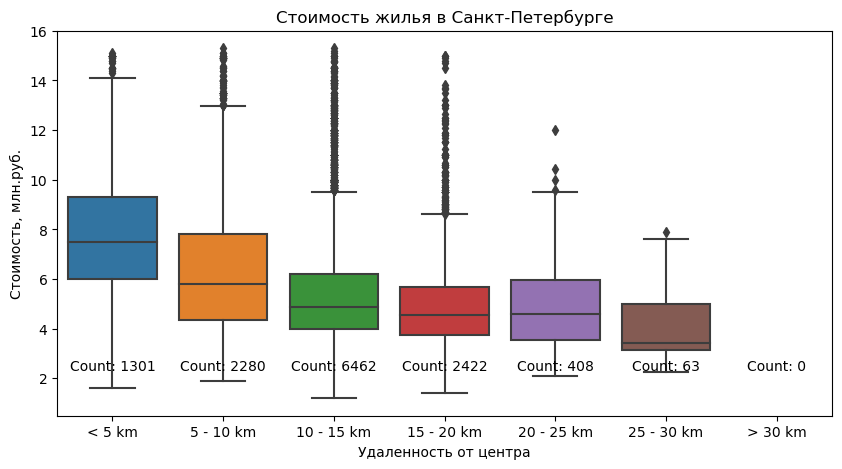

In [41]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='distance_cats', y='last_price_mln', data=data_peter)

plt.xlabel('Удаленность от центра')
plt.ylabel('Стоимость, млн.руб.')
plt.title('Стоимость жилья в Санкт-Петербурге')

counts = data_peter['distance_cats'].value_counts()
xticks_positions = ax.get_xticks()
xticks_labels = [i.get_text() for i in ax.get_xticklabels()]

for i, year in zip(xticks_positions, xticks_labels):
    ax.text(i, data_peter['last_price_mln'].min() + 1, f'Count: {counts[year]}', ha='center', va='bottom')

plt.show()

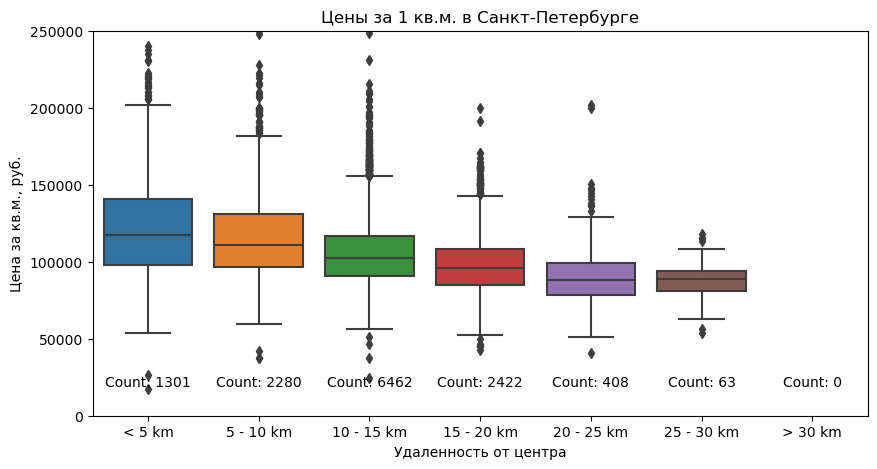

In [42]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='distance_cats', y='price_per_m2', data=data_peter)

plt.xlabel('Удаленность от центра')
plt.ylabel('Цена за кв.м., руб.')
plt.title('Цены за 1 кв.м. в Санкт-Петербурге')

counts = data_peter['distance_cats'].value_counts()
xticks_positions = ax.get_xticks()
xticks_labels = [i.get_text() for i in ax.get_xticklabels()]

for i, year in zip(xticks_positions, xticks_labels):
    ax.text(i, data_peter['price_per_m2'].min(), f'Count: {counts[year]}', ha='center', va='bottom')

plt.ylim((0,250000))

plt.show()

Также можно заметить, что в центре города присутствует больший разброс на цены. По мере удаления от центра города квартиры становятся более однообразными - разброс цен уменьшается

### Общий вывод

Был получен датасет на 23699 строк и 22 столбца.

На этапе предобработки данных было проведено:

Обработка пропусков
* Удалены строки с пропусками в `locality_name`.
* Пропуски в `is_apartment` заменены на значения `False`.
* Пропуски в `balcony` заменены на значение 0.
* 
Типы данных:
* Столбец `first_day_exposition` переведен в формат даты.
* Столбец `is_apartmen` переведен в boolean
* Исправлены неявные дубликаты в столбце `locality_name`.
* 
Лемматизация:
* Применена лемматизация названий для исключения неявных дубликатов. Количество уникальных названий сокращено с 364 до 331

Обработка аномалий
* `is_apartment`, `studio`, `open_plan` - оставлен только преобладающий класс 'False', а столбцы исключены из исследования
* `last_price_mln`, `total_area`, `living_area`, `kitchen_area`, `rooms`, `ceiling_height`, `balcony` - данные ограничены по 95% перцентилю сверху
* и `last_price_mln`, `ceiling_height` также ограничены снизу по 1% перцентилю
* В итоге в датасете для исследования осталось 85% строк от изначальных данных

Были добавлены новые столбцы: 
* цена 1 квадратного метра, 
* день недели, месяц и год публикации, 
* тип этажа - первый / последний / другой
* признак удаленности от центра города разбит на категории по 5км

EDA

Был исследован параметр `days_exposition`.  
* Среднее значение дней продажи: 172 дней
* Медианное значение дней продажи: 91 дней
* 95% перцентиль: 616 дней.

Продажу ниже медианного значения 91 дней можно считать быстрой. Продажу дольше 95% перцентиля 616 дней можно считать слишком долгой

Корреляция. Был использован коэффициент корреляции фи '$\phi$'
* Больше всего на цену жилья влияет площадь этого жилья. Причем общая площадь имеет большее значение, чем площади кухни или жилой зоны в отдельности.
* Название населенного пункта на 2 месте по влиянию на цену.
* Дальше по значимости идет высота потолков и удаленность от центра города    
* Дальше - количество комнат.
* Также небольшое влияние оказывает этаж квартиры, этажность здания и тип этажа
* Удаленность парков, прудов и аэропорта оказывают наименьшее влияние на цену, как и наличие балкона

Некоторые подробности
* На матрицах рассеяния для зависимости цены от общей площади можно проследить, что в Санкт-Петербурге разброс цен наибольший, т.к. на цену значительное влияние оказывают также и другие параметры. В других населенных пунктах линейная зависимость прослеживается более четко - влияние остальных параметров на цену ниже.
* С ростом количества комнат цена жилья возрастает. Также возрастает и разброс цен на жилье с ростом количества комнат.
* Первый и последний этаж стоят немного меньше остальных типов
* За период 2015-2019 медиана стоимости жилья осталась на том же уровне, выросла цена за 1 квадратный метр

Цена за квадратный метр
* Самый дорогой квадратный метр - в Санкт-Петербурге
* Помере удаления от центра в Санкт-Петербурге цена на квартиры падает примерно до 10км, дальше держится примерно на одном уровне
* При этом цена за 1 квадратный метр падает постоянно вплоть до окраины (около 30км). Т.е. по мере движения от края города к центру цена сохраняется примерно на одном уровне за счет уменьшения площади. Ближе 10км от центра стоимость растет, также как и разнообразие квартир с разными ценами.м.